# Try using HDBSCAN to cluster things

Links:
* [HDBSCAN vs other clustering algorithms - an exploration](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)
* [sklearn HDBSCAN docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

## Notes to self

do I need to normalize the data?

In [1]:
ls agatha-genomes.10k.presence.csv

agatha-genomes.10k.presence.csv


In [2]:
from sourmash import sourmash_args
import numpy
import seaborn as sns
import sklearn.cluster
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D

## First, try looking at the sample presence matrix

In [3]:
csvfile = 'agatha-genomes.10k.presence.csv'

In [4]:
with sourmash_args.FileInputCSV(csvfile) as r:
    rows = list(r)

# pick out all the distinct queries/matches.                            
print(f"loaded {len(rows)} rows from '{csvfile}'")
queries = set([row["query_name"] for row in rows])
against = set([row["match_name"] for row in rows])
print(f"loaded {len(queries)} x {len(against)} total elements")

queries = list(sorted(queries))
against = list(sorted(against))

query_d = {}
for n, query_name in enumerate(queries):
    query_d[query_name] = n

against_d = {}
for n, against_name in enumerate(against):
    against_d[against_name] = n

query_d_items = list(sorted(query_d.items(), key=lambda x: x[1]))
against_d_items = list(sorted(against_d.items(), key=lambda x: x[1]))


loaded 225780 rows from 'agatha-genomes.10k.presence.csv'
loaded 91 x 6388 total elements


In [5]:
mat = numpy.zeros((len(queries), len(against)))

for row in rows:
    q = row["query_name"]
    qi = query_d[q]
    m = row["match_name"]
    mi = against_d[m]
    value = float(row['presence'])

    mat[qi, mi] = value


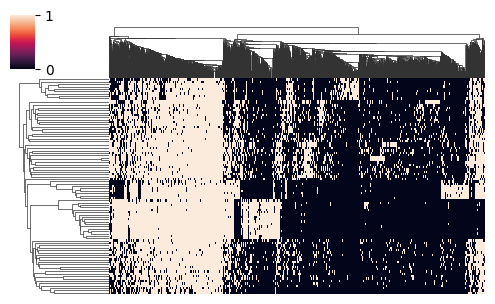

In [6]:
sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(5, 3))

got 1 labels


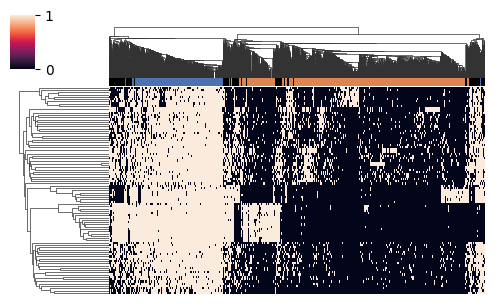

In [7]:
min_cluster_size=135
labels = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(1 - mat.T)

print(f'got {numpy.unique(labels).max()} labels')
palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(5, 3), col_colors=colors)

## Try with association matrix instead, w/distance precomputed...

In [8]:
cmp = numpy.load('agatha-genomes.10k.assoc')
cmplabelsfile = 'agatha-genomes.10k.assoc.labels.csv'
categories_file = 'agatha-genomes.10k.assoc.categories.csv'

In [9]:
from sourmash_plugin_betterplot import load_categories_csv
with sourmash_args.FileInputCSV(cmplabelsfile) as r:
    labelinfo = list(r)
category_map, category_colors = load_categories_csv(categories_file, labelinfo)

found category key: label


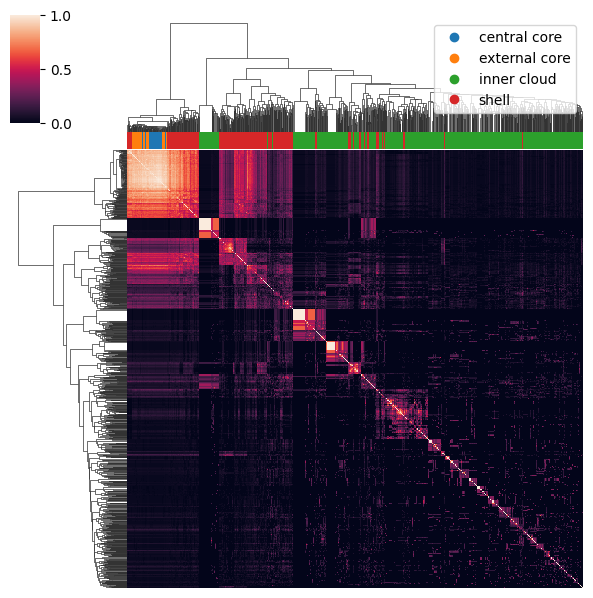

In [10]:
fig = sns.clustermap(cmp, xticklabels=[], yticklabels=[], figsize=(6, 6), col_colors=category_colors)

# create a custom legend of just the pangenome rank colors on the columns                     
legend_elements = []
for k, v in category_map.items():
    legend_elements.append(
        Line2D([0], [0], color=v, label=k, marker="o", lw=0)
    )
fig.ax_col_dendrogram.legend(handles=legend_elements)


got 8 labels


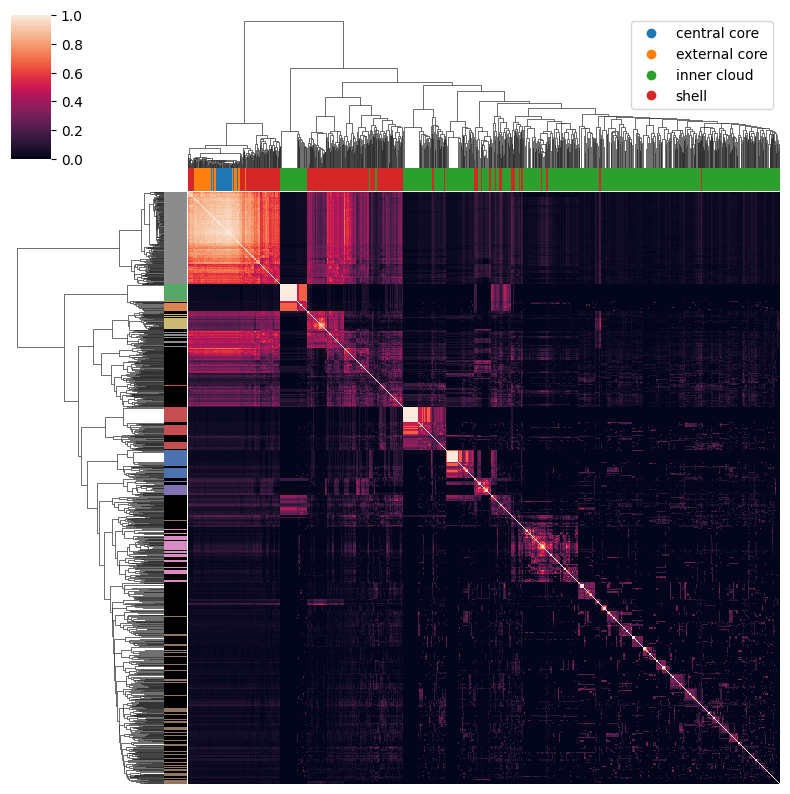

In [11]:
min_cluster_size=15
labels = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(1 - cmp)

print(f'got {numpy.unique(labels).max()} labels')
palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
cluster_colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

fig = sns.clustermap(cmp, xticklabels=[], yticklabels=[], figsize=(8, 8), row_colors=cluster_colors, col_colors=category_colors)

# create a custom legend of just the pangenome rank colors on the columns                     
legend_elements = []
for k, v in category_map.items():
    legend_elements.append(
        Line2D([0], [0], color=v, label=k, marker="o", lw=0)
    )
fig.ax_col_dendrogram.legend(handles=legend_elements)

### (MDS viz is not particularly helpful, it seems)

In [12]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(1 - cmp)


ValueError: 'c' argument has 6388 elements, which is inconsistent with 'x' and 'y' with size 1160.

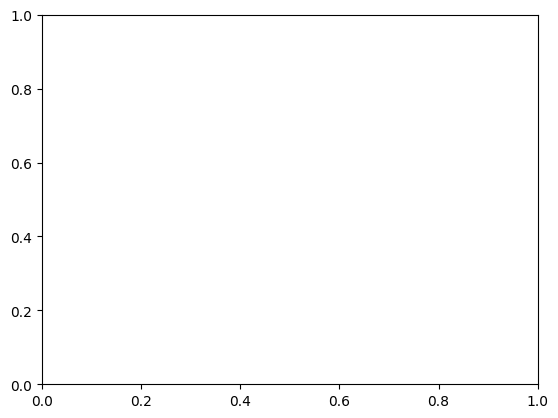

In [13]:
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], color=clcolors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

## What about t-SNE?

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, perplexity=50) # play with: perplexity
tsne_coords = tsne.fit_transform(1 - cmp)


In [ ]:
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], color=colors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

In [ ]:
## ok, whatever, pull out the clusters ;)

hashinfo = list(labelinfo)

hashinfo.sort(key=lambda row: int(row["sort_order"]))
hashvals = [ int(row['label']) for row in hashinfo ]

clusters_d = defaultdict(set)

for hashval, cluster_num in zip(hashvals, labels):
    if cluster_num >= 0:
        clusters_d[cluster_num].add(hashval)

In [ ]:
print(len(clusters_d))

In [ ]:
for k, v in sorted(clusters_d.items()):
    print(f"cluster {k} has size {len(v)}")

# TODO

* turn clusters into sketches, I guess? :)